# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In [2]:
%matplotlib inline

## Organize data

The first step was to organize the data into a folder structure that fits keras. 

/train

with one folder per dog race in train/valid set

### Read labels and move to train

In [26]:
import os

with open('labels.csv') as f:
    for line in f:
        words = line.rstrip().split(',')
    id = words[0]
    label = words[1]

    label_dir = 'train/' + label
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    print(id, label);
    os.rename(('train/' + id  +'.jpg'), (label_dir + '/' + id + '.jpg'))

affenpinscher/                   italian_greyhound/
afghan_hound/                    japanese_spaniel/
african_hunting_dog/             keeshond/
airedale/                        kelpie/
american_staffordshire_terrier/  kerry_blue_terrier/
appenzeller/                     komondor/
australian_terrier/              kuvasz/
basenji/                         labrador_retriever/
basset/                          lakeland_terrier/
beagle/                          leonberg/
bedlington_terrier/              lhasa/
bernese_mountain_dog/            malamute/
black-and-tan_coonhound/         malinois/
blenheim_spaniel/                maltese_dog/
bloodhound/                      mexican_hairless/
bluetick/                        miniature_pinscher/
border_collie/                   miniature_poodle/
border_terrier/                  miniature_schnauzer/
borzoi/                          newfoundland/
boston_bull/                     norfolk_terrier/
bouvier_des_flandres/            norwegian_elkhound

In [13]:
#path = "data/dogs/"
DATA_PATH = path
model_path = "model/"
batch_size = 64

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
import pandas as pd
import re
from keras.utils.data_utils import get_file
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from PIL import Image
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Dropout, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback


Using Theano backend.
ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import *

# Preprocess image size and create generators

In [14]:
train_gen = ImageDataGenerator().flow_from_directory(path + "train",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              target_size=(224, 224),
                                              shuffle=False);
val_gen = ImageDataGenerator().flow_from_directory(path + "valid",
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          target_size=(224, 224),
                                          shuffle=False)

Found 581 images belonging to 7 classes.
Found 62 images belonging to 7 classes.


In [58]:
train_gen.class_indices

7

581

## Vgg19 model

In [59]:
# Import our class, and instantiate
im_size=224
num_class=len(train_gen.class_indices)

#Input layer size of reshaped images
img_input = Input(shape=(3, im_size, im_size))
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=img_input)

In [60]:

# Add a new top layer
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(num_class, activation='softmax', name='predictions')(x)

# This is the model we will train
model = Model(base_model.input, x)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  0           input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Change image to array

In [17]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]


### Get data (instead of using the image generator flow (time consuming)

In [47]:
val_data = get_data(path + 'valid')
trn_data = get_data(path + 'train')

Found 62 images belonging to 7 classes.
Found 581 images belonging to 7 classes.


### Save data

In [37]:
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

### Load data (no neet to get it)

In [ ]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [48]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [49]:
val_classes = val_gen.classes
trn_classes = train_gen.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [25]:
gen=image.ImageDataGenerator()
train_gen = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_gen = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Epoch 1/1
581/581 [==============================] - 361s - loss: 15.6499 - acc: 0.0224 - val_loss: 13.2584 - val_acc: 0.1774



## Load weights

### Load last saved weights

In [80]:
latest_weights_filename = path + 'weights–ft%d.h5'

vgg.model.load_weights(latest_weights_filename)

## Train

In [86]:
nb_epoch=1
history = model.fit_generator(train_gen, samples_per_epoch=train_gen.N, nb_epoch=nb_epoch, 
                        validation_data=val_gen, nb_val_samples=val_gen.N, callbacks=[TQDMNotebookCallback()])

Found 9235 images belonging to 120 classes.
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_ho

### Save weights after 3 epochs

In [28]:
results_filename = path + 'weights–ft%d-one-epoch.h5'
vgg.model.save_weights(results_filename)

### Testing

In [65]:
batch_size=64
test_batches = ImageDataGenerator().flow_from_directory(path + "test", 
                                          batch_size=batch_size * 2,
                                          class_mode=None,
                                          target_size=(224, 224), 
                                          shuffle=False)
predictions = model.predict_generator(test_batches, test_batches.nb_sample)


Found 44 images belonging to 1 classes.


In [68]:
filenames = test_batches.filenames
expected_labels = test_batches.classes
our_labels = np.argmax(predictions, axis=1)

### Testing validation set

In [13]:
batch_size=64
validation_batches = ImageDataGenerator().flow_from_directory(path + "valid", 
                                          batch_size=batch_size * 2,
                                          class_mode=None,
                                          target_size=(224, 224), 
                                          shuffle=False)
validation_predictions = model.predict_generator(test_batches, test_batches.nb_sample)

Found 987 images belonging to 120 classes.


In [67]:
filenames = validation_batches.filenames
expected_labels = validation_batches.classes
our_labels = np.argmax(validation_predictions, axis=1)

NameError: name 'validation_batches' is not defined

### Export predictions

In [ ]:
ids = list(map(lambda x: [re.search('.+\/(.+)\.jpg', x).group(1)], test_batches.filenames))
subm = np.hstack((ids, predictions))
class_str = ','.join(['id'] + vgg.classes)
N = len(vgg.classes)
format_str = ','.join(['%s'] + ['%s']*N)
submission_file_name = 'dogs_races.csv'
np.savetxt(submission_file_name, subm, fmt=format_str, header=class_str, comments='')

### Create a downloadable link

In [21]:
from IPython.display import FileLink
submission_file_name = 'dogs_races.csv'
FileLink(submission_file_name)

/home/ubuntu/courses/deeplearning1/nbs/dogs_races.csv

## Save results so they can be reused

In [48]:
results_path = path + 'results/'
save_array(results_path + 'test_preds.dat', predictions)
save_array(results_path + 'filenames.dat', test_batches.filenames)

## Save validaton results

In [14]:
results_path = path + 'results/'
save_array(results_path + 'validation_test_preds.dat', validation_predictions)
save_array(results_path + 'validation_filenames.dat', validation_batches.filenames)

## Load last results

In [8]:
results_path = path + 'results/'
predictions = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

## Load validation results

In [ ]:
results_path = path + 'results/'
validation_predictions = load_array(results_path + 'validation_test_preds.dat')
filenames = load_array(results_path + 'validation_filenames.dat')
vgg.finetune(batches)

## Identified dog races

In [15]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/' + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

## Five best matches

In [50]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx)

Found 695 correct labels


## Five worst matches

In [51]:
incorrect = expected_labels - our_labels
print "Found %d incorrect cats" % len(incorrect)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

SyntaxError: invalid syntax (<ipython-input-51-597184a4305d>, line 2)

In [83]:
most_wrong = expected_labels - our_labels
most_wrong = np.absolute(most_wrong)
print(most_wrong)

[ 16   0   0   0   0   0   0   0   5   0  92  22   0  31   0  57   0   0   0   0   0   0  93   0   0
   0   0   0   0  65   0   0   0  54   0   0   0 100   0 100 100  20  37  37   0   0   0  37  35   0
  37  37   0   0   0   0   0 113   0   3   0   0 104   0  48   0   0   0  30   0   0   0   2   0   0
   0   1   0   0  84   0   0   0  24   0   0 104  91  84   0   0 104  30   0  30   1   0  49   0   0
   0   0   0   0  95  58  58   0   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0   2   0
  79   0   0  30  48  19   0  42   0  98  76   0  76   0   0   0   0  36   0  75  32   0   0  75   0
   0  27   0   0   0   0   0  38   0  25   0  42   0   0   0   0   0   0   0   0  34  75   0   0  95
   0   0   0   0   0   0   0   0   0   0   0   0   0  28   0  44   3   0   0   0   0   0   0   0  17
  30   0  71   0  15   0   0   0   0   0   0  38   0  58   0  25   0   0   0   0  22   0  91   0   0
   0   0   0   0   0   0   0  65  79   0  63   0  79   0   0   0   0   0   0  55   0  83   

In [95]:
top_wrong = most_wrong.argsort()[-30:][::-1]

In [96]:
for idx in top_wrong: 
    ex_lab = expected_labels[idx]
    our_lab = our_labels[idx]
    print("expected", vgg.classes[ex_lab])
    print("got ", vgg.classes[our_lab])


expected wire-haired_fox_terrier
got  airedale
expected yorkshire_terrier
got  australian_terrier
expected yorkshire_terrier
got  australian_terrier
expected yorkshire_terrier
got  australian_terrier
expected yorkshire_terrier
got  australian_terrier
expected australian_terrier
got  yorkshire_terrier
expected vizsla
got  airedale
expected welsh_springer_spaniel
got  basset
expected welsh_springer_spaniel
got  basset
expected walker_hound
got  basset
expected beagle
got  walker_hound
expected beagle
got  walker_hound
expected basenji
got  toy_terrier
expected yorkshire_terrier
got  bluetick
expected american_staffordshire_terrier
got  staffordshire_bullterrier
expected american_staffordshire_terrier
got  staffordshire_bullterrier
expected american_staffordshire_terrier
got  staffordshire_bullterrier
expected bloodhound
got  vizsla
expected silky_terrier
got  australian_terrier
expected silky_terrier
got  australian_terrier
expected silky_terrier
got  australian_terrier
expected borzoi
g

6

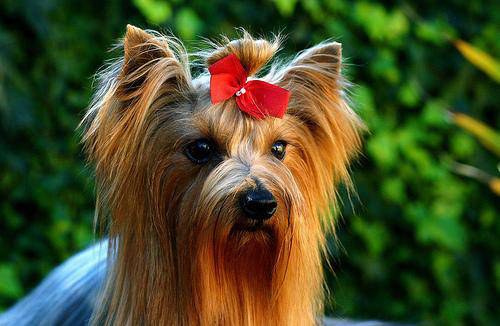

In [68]:
Image.open(path+'valid/' + filenames[top_wrong[3]])